# Modelling and Evaluation

## Objectives

- Complete model to predict if a cherry leaf is infected with powdery mildew, which is the primary Business Requirement
- 2 models will be created and trained, one with a Softmax output and another with a Sigmoid output, in order to find the best possible model

## Inputs

- inputs/cherry_leaves_raw_dataset/cherry-leaves/train
- inputs/cherry_leaves_raw_dataset/cherry-leaves/validation
- inputs/cherry_leaves_raw_dataset/cherry-leaves/test
Each folder has 2 subfolders: 'healthy' and 'powdery_mildew'
- image_shape pkl [pickle] file


## Outputs

- Image distribution plot, train vs validation vs test
- Class_indices.pkl
- Machine learning model creation and training (mildew_detection_model)
- evaluation.pkl
- Plotting model performance, model_training_acc.png, model_training_losses.png
<!-- - validation_set_confusion_matrix.png, test_set_confusion_matrix.png -->
- Prediction on selected image files

## Install dependencies

In [85]:
pip install -r /workspace/mildew-detection/requirements.txt

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [86]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread


## Change working directory

Change working directory from current to parent folder.

In [87]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

In [88]:
os.chdir("/workspace/mildew-detection")
print("You set a new current directory.")

You set a new current directory.


In [89]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

## Set input directories

In [90]:
data_dir = "inputs/cherry_leaves_raw_dataset/cherry-leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

## Set output directories

In [91]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory already exists, please create a new version if required.")
else:
    os.makedirs(name=file_path)

This directory already exists, please create a new version if required.


## Set label names

In [92]:
labels = os.listdir(train_dir)
print("The image labels are ", labels)

The image labels are  ['healthy', 'powdery_mildew']


Set image shape

In [93]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(80, 80, 3)

## Check number of images in the respective sets

Set size will be plotted as bar and pie charts and the images saved to outputs

### Bar chart

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


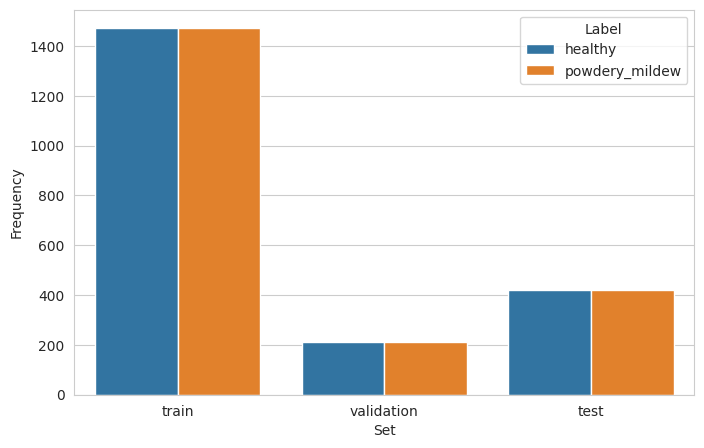

In [94]:
# A dataframe is initialised to store the data
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

folders = ['train', 'validation', 'test']

# Iterate through folders, labels, and count the images present
for folder in folders:
    for label in labels:
        folder_path = os.path.join(data_dir, folder, label)
        num_images = len(os.listdir(folder_path))
        df_freq = df_freq.append({'Set': folder, 'Label': label, 'Frequency': num_images}, ignore_index=True)
        print(f"* {folder} - {label}: {num_images} images")

# Plot label distribution barchart
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_distrib_pre_augmentation.png', bbox_inches='tight', dpi=150)
plt.show()

### Pie chart

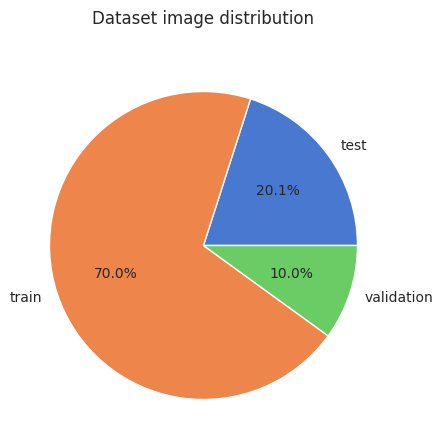

In [95]:
folders = os.listdir(data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(10,5))
colors = sns.color_palette('muted')[0:9]
plt.pie(data, labels = folders, colors = colors, autopct='%.1f%%')
plt.title(f'Dataset image distribution\n')
plt.savefig(f'{file_path}/image_distribution_pie.png', bbox_inches='tight', dpi=150)
plt.show()

It can be seen that they're split 70/10/20 to the nearest percent

## Model creation: Softmax vs Sigmoid

One of each type of model will be created to see which can solve the problem best. **Augmentation must be run for each model, as the class_mode is different** in the augmentation process

In this notebook a Softmax activation function model will be created and tested

## Image augmentation (Softmax)

ImageDataGenerator will be used to augment the image pool as the data is loaded

The ImageDataGenerator is imported and initialised

In [96]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

The image pool for each set is augmented

### Train set

In [97]:
batch_size = 32
train_set = augmented_image_data.flow_from_directory(train_dir, # Take images from 'train' folder
                                                    target_size=image_shape[:2], 
                                                    color_mode='rgb',
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', # softmax activation requires this set to categorical
                                                    shuffle=False # Shuffle the images
                                                    )
train_set.class_indices    

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Validation set

In [98]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Test set

In [119]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=True
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Save class_indices as a pkl file 

In [100]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

## Plot augmented images for each set (showing 2 sample images from each)

### Train set

(32, 80, 80, 3)


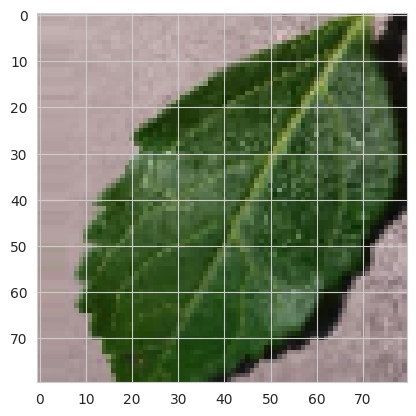

(32, 80, 80, 3)


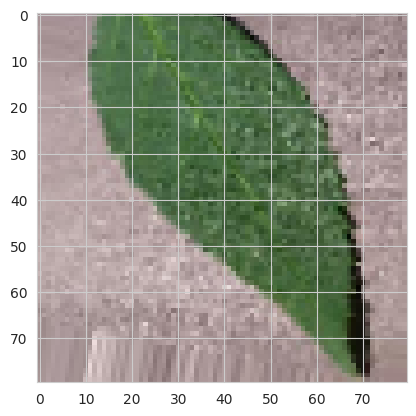

In [101]:
for _ in range(2):
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Validation set

(32, 80, 80, 3)


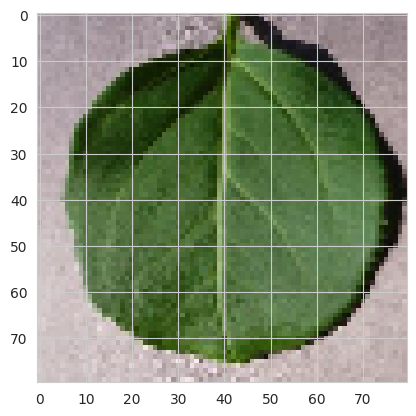

(32, 80, 80, 3)


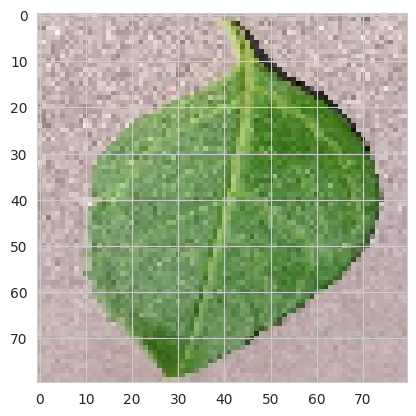

In [102]:
for _ in range(2):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Test set

(32, 80, 80, 3)


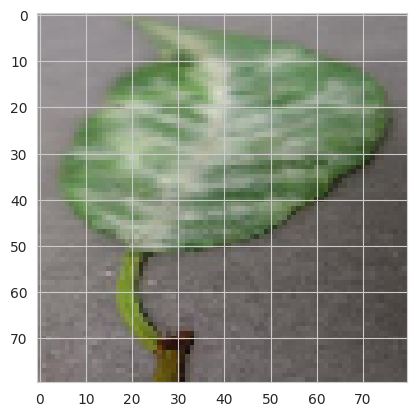

(32, 80, 80, 3)


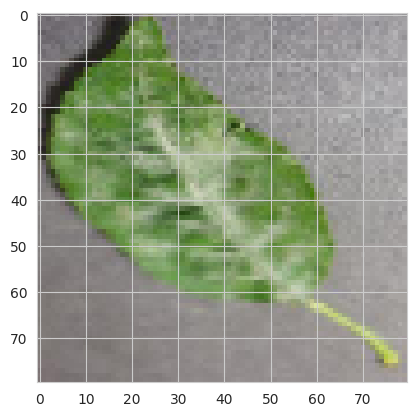

In [103]:
for _ in range(2):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

# Machine Learning Model Creation (Softmax)

Create softmax output model

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf


def create_model_softmax():
    model = Sequential()

    # input layer
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # convolution layers
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.1))

    model.add(Conv2D(filters=128, kernel_size=(4,4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))

    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='tanh', padding='same'))
    model.add(MaxPooling2D(pool_size=(1,1)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.3))

    # output
    model.add(Dense(2, activation = 'softmax'))

    model.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

    return model


Show a summary of the softmax model

In [105]:
model = create_model_softmax()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          102464    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 64)         

In [106]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [107]:

model.fit(train_set, epochs=30, 
        steps_per_epoch=len(train_set.classes) // batch_size,
        validation_data=validation_set,
        callbacks=[early_stop],
        verbose=1
        )


Epoch 1/30


92/92 [==============================] - 13s 135ms/step - loss: 0.6968 - accuracy: 0.4671 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/30
92/92 [==============================] - 12s 132ms/step - loss: 0.6927 - accuracy: 0.5071 - val_loss: 0.6399 - val_accuracy: 0.8976
Epoch 3/30
92/92 [==============================] - 12s 130ms/step - loss: 0.7161 - accuracy: 0.6107 - val_loss: 0.5217 - val_accuracy: 0.7190
Epoch 4/30
92/92 [==============================] - 12s 131ms/step - loss: 0.3584 - accuracy: 0.8628 - val_loss: 0.1967 - val_accuracy: 0.9071
Epoch 5/30
92/92 [==============================] - 12s 130ms/step - loss: 0.1894 - accuracy: 0.9256 - val_loss: 0.1172 - val_accuracy: 0.9690
Epoch 6/30
92/92 [==============================] - 12s 131ms/step - loss: 0.1325 - accuracy: 0.9541 - val_loss: 0.0547 - val_accuracy: 0.9833
Epoch 7/30
92/92 [==============================] - 12s 132ms/step - loss: 0.0913 - accuracy: 0.9711 - val_loss: 0.0450 - val_accuracy: 0.9857
Epoch 8/30

In [108]:
model.save('outputs/v1/mildew_detection_model_1.h5')

# Softmax Model performance

## Model learning curve

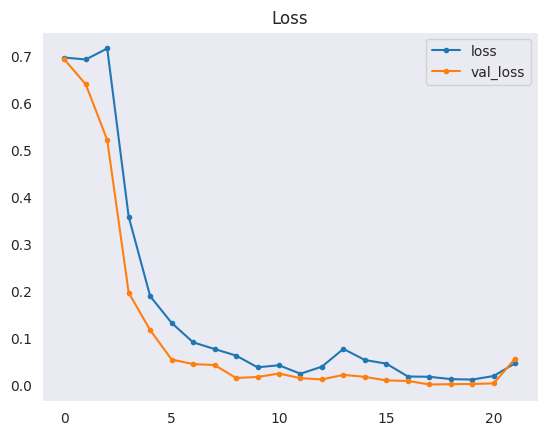

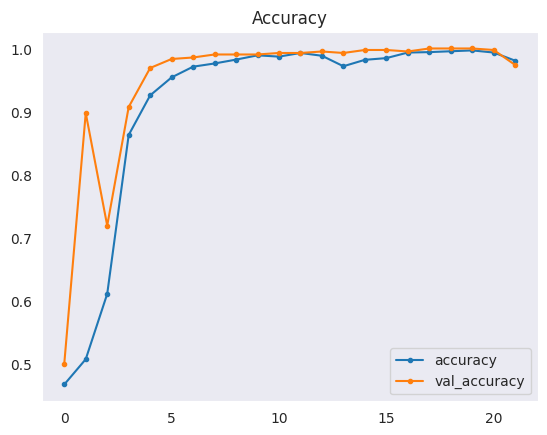

In [111]:
losses = pd.DataFrame(model.history.history)

sns.set_style("dark")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses_softmax.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
# plt.savefig(f'{file_path}/model_training_acc_softmax.png', bbox_inches='tight', dpi=150)
plt.show()

## Softmax Model evaluation

Load saved model

In [113]:
from keras.models import load_model
model_soft = load_model('outputs/v1/mildew_detection_model_1.h5')

Check model performance on test set

In [120]:
evaluation = model_soft.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: {:.4f}%".format(evaluation[0]))

 6/27 [=====>........................] - ETA: 1s - loss: 0.0271 - accuracy: 0.9896

27/27 [==============================] - 2s 69ms/step - loss: 0.0517 - accuracy: 0.9775
Model accuracy: 97.75%
Model Loss: 0.0517%


Save evaluation pkl file

In [117]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation_softmax.pkl")

['outputs/v1/evaluation_softmax.pkl']

## Predict on new data

An image from the 'healthy' label is fed into the model to randomly check accuracy

Image shape: (80, 80), Image mode: RGB


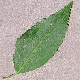

In [ ]:
from tensorflow.keras.preprocessing import image
import random

label = labels[0]  # label '0' = 'healthy'
image_files = os.listdir(test_dir + '/' + label)
random_image_file = random.choice(image_files)

pil_image = image.load_img(test_dir + '/' + label + '/' + random_image_file,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to an array for prediction

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


The prediction is run

In [ ]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
prediction_class = target_map[prediction_probability < 0.5]

if prediction_class == target_map[1]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

1.0
healthy


The steps above are repeated for a random infected image as a second check

Image shape: (80, 80), Image mode: RGB


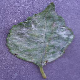

In [ ]:
from tensorflow.keras.preprocessing import image
import random

label = labels[1]  # label '1' = 'powdery_mildew'
image_files = os.listdir(test_dir + '/' + label)
random_image_file = random.choice(image_files)

pil_image = image.load_img(test_dir + '/' + label + '/' + random_image_file,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


In [ ]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
prediction_class = target_map[prediction_probability < 0.5]

if prediction_class == target_map[1]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

0.9999999999999993
powdery_mildew


Show contents of .gitignore

In [ ]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

# Conclusions

- A Softmax model was created and the parameters/hyperparameters tuned using different numbers of layers, nodes, kernel sizes, dropout layers, pool sizes, loss metrics, epochs and optimizers and emerged as extremely accurate (>99%). The business requirement of 97% was easily met
- A larger dataset, as well as further tuning of hyperparameters may help to refine accuracy, though the model already performs far above the required 97% - there's not a lot of room to improve further. Larger image sizes (I resized to 80 by 80) would also give more data for the model to work with, but increase the size of the deployment to unacceptable levels

## Next steps

- A Sigmoid model will be created to see if it can outperform the Softmax model, before deciding which to carry forward to the final production step